Lade Daten...
Daten geladen.
Erstelle Monats-Plot...


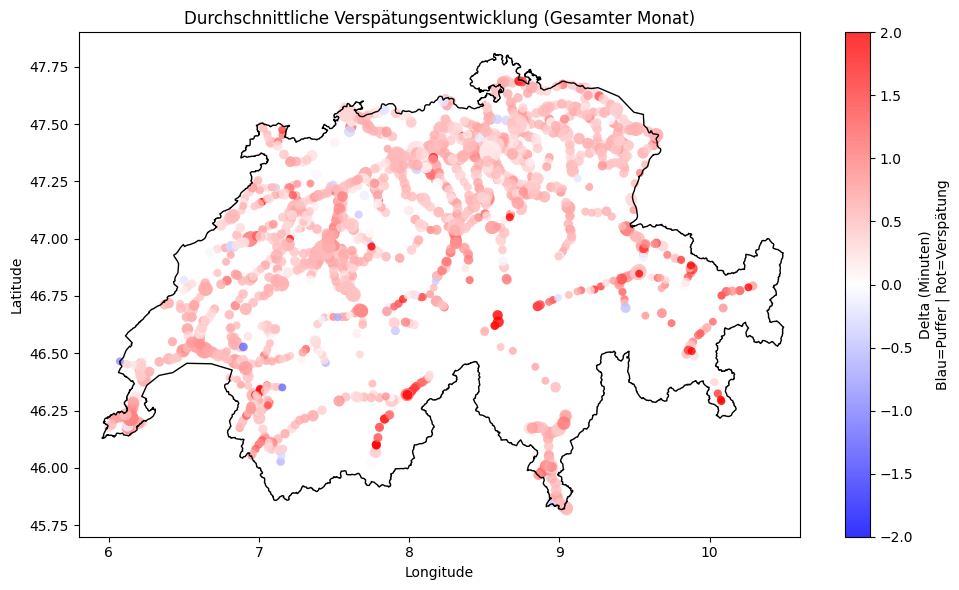

Erstelle Tages-Plots...
Plotting 2025-09-01...


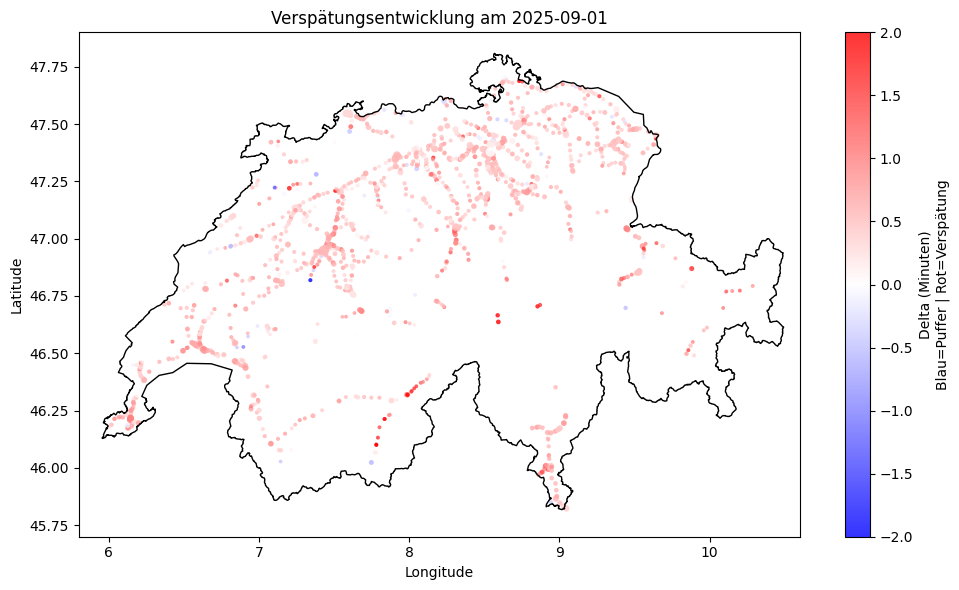

Plotting 2025-09-02...


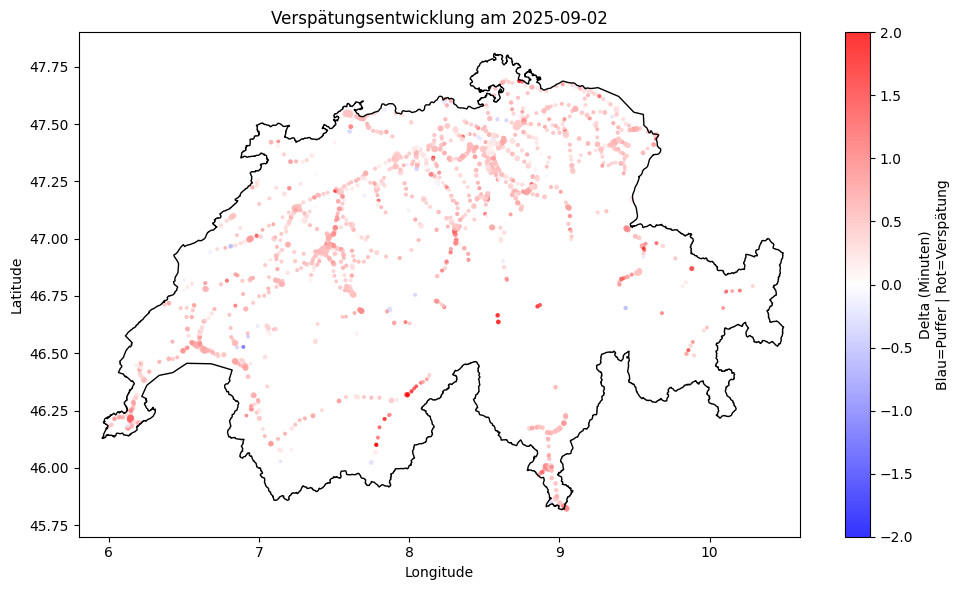

Plotting 2025-09-03...


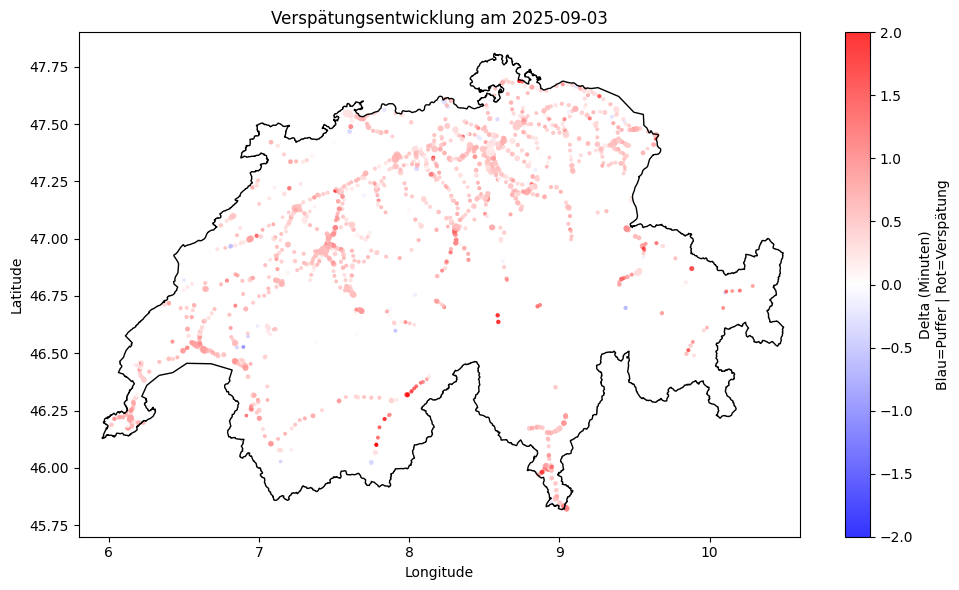

Plotting 2025-09-04...


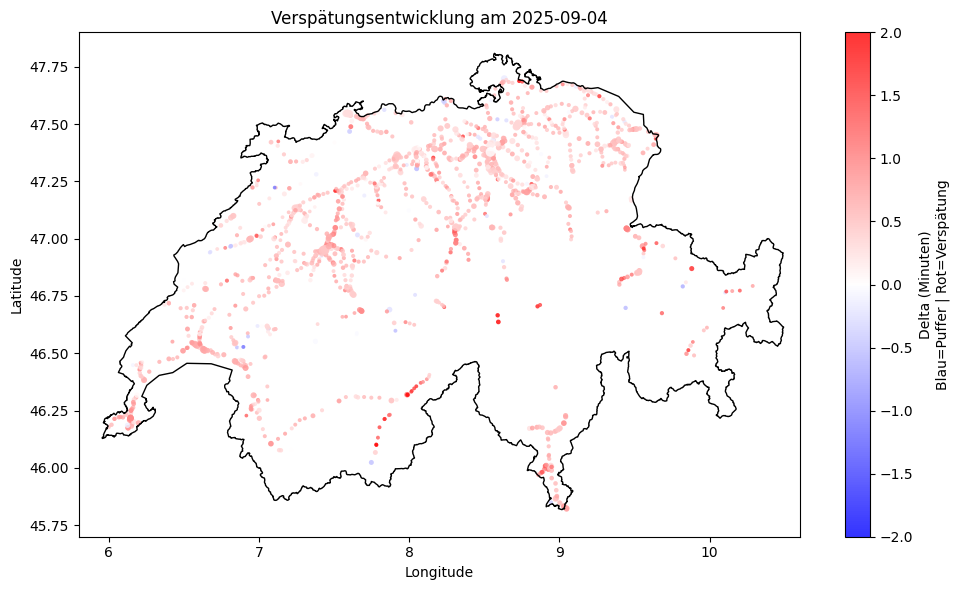

Plotting 2025-09-05...


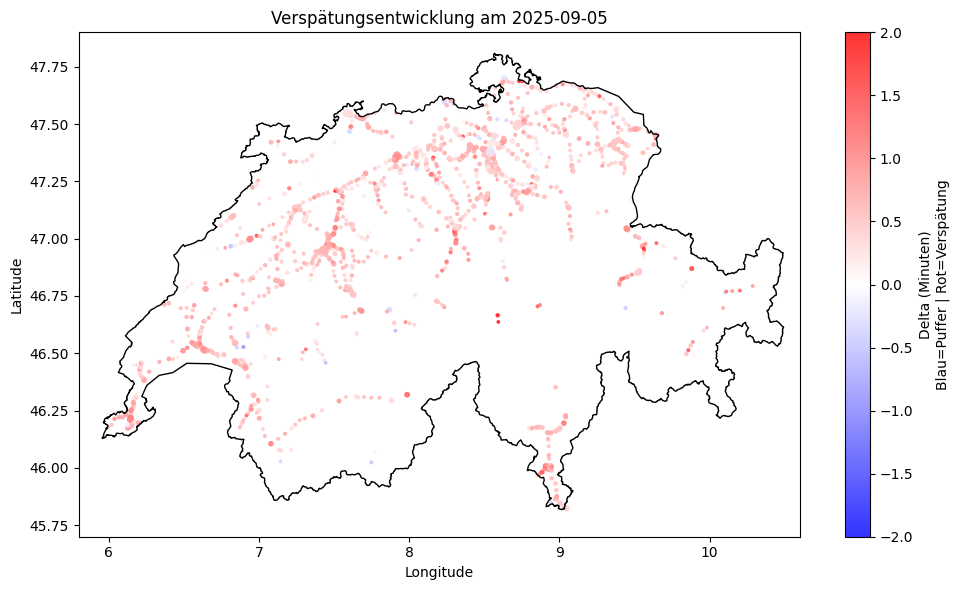

Plotting 2025-09-06...


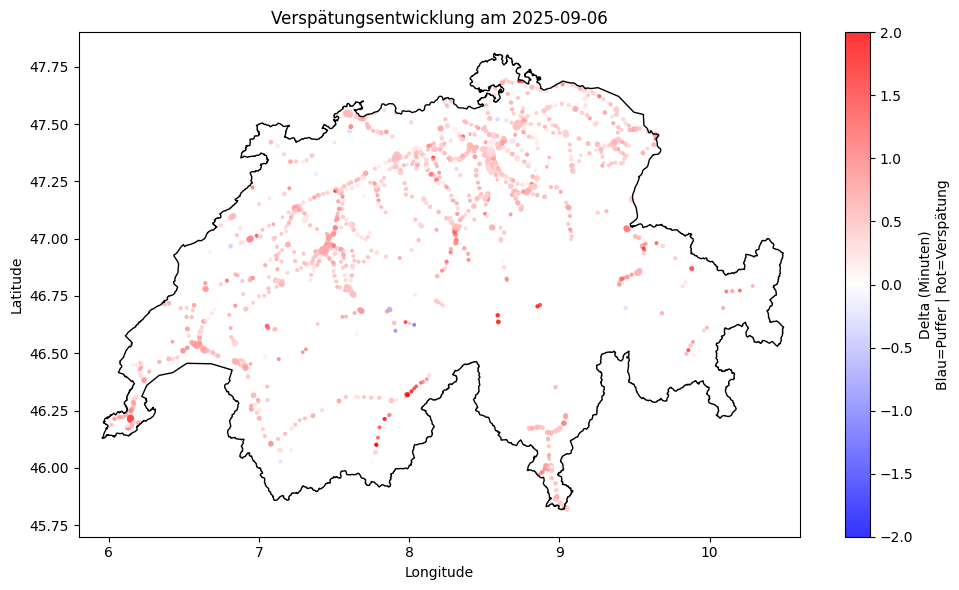

Plotting 2025-09-07...


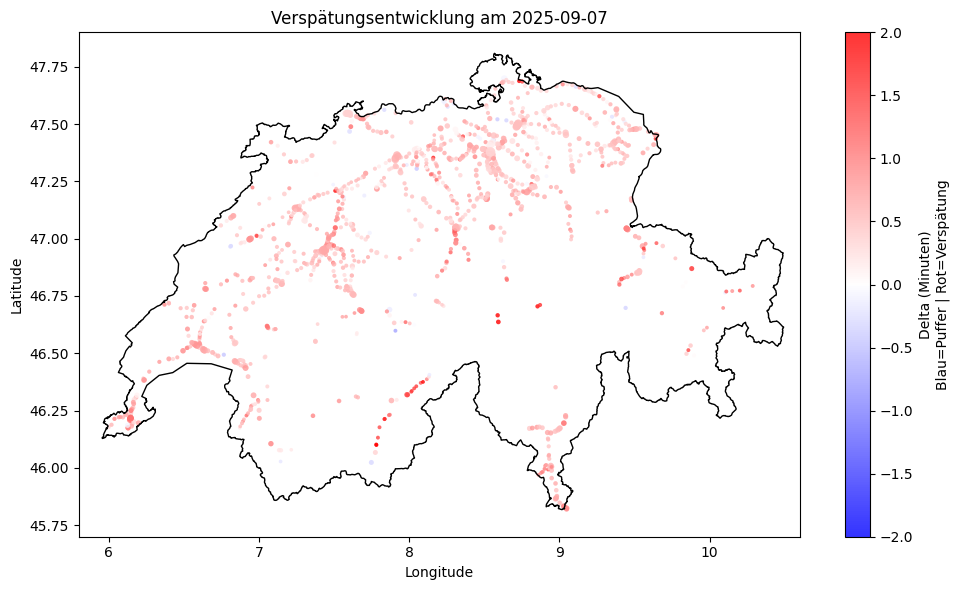

Plotting 2025-09-08...


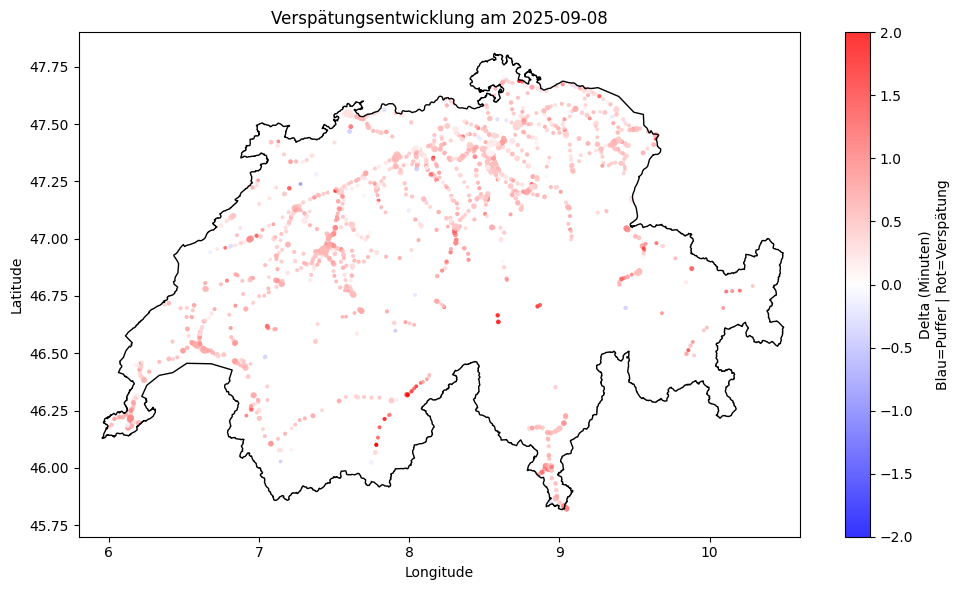

Plotting 2025-09-09...


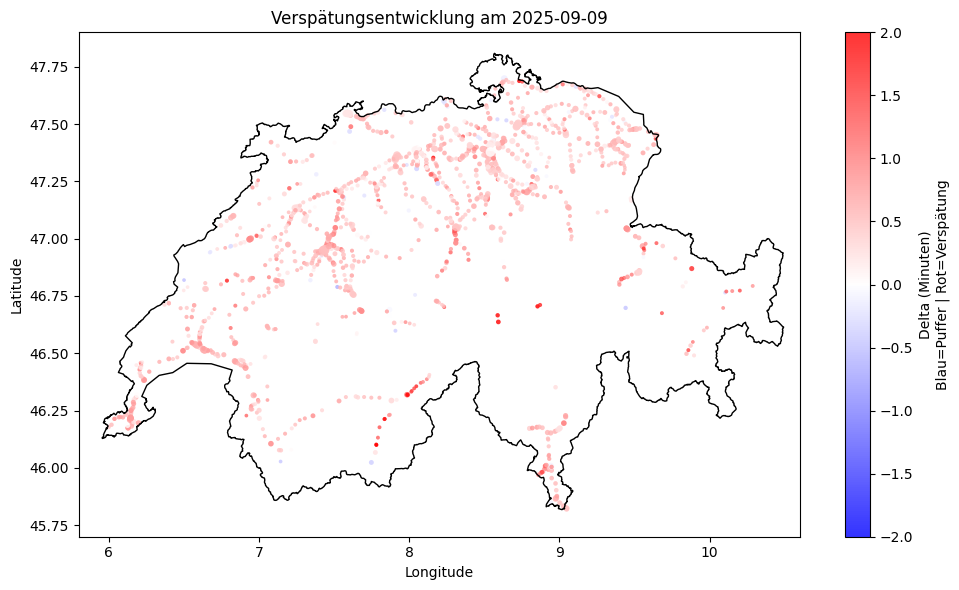

Plotting 2025-09-10...


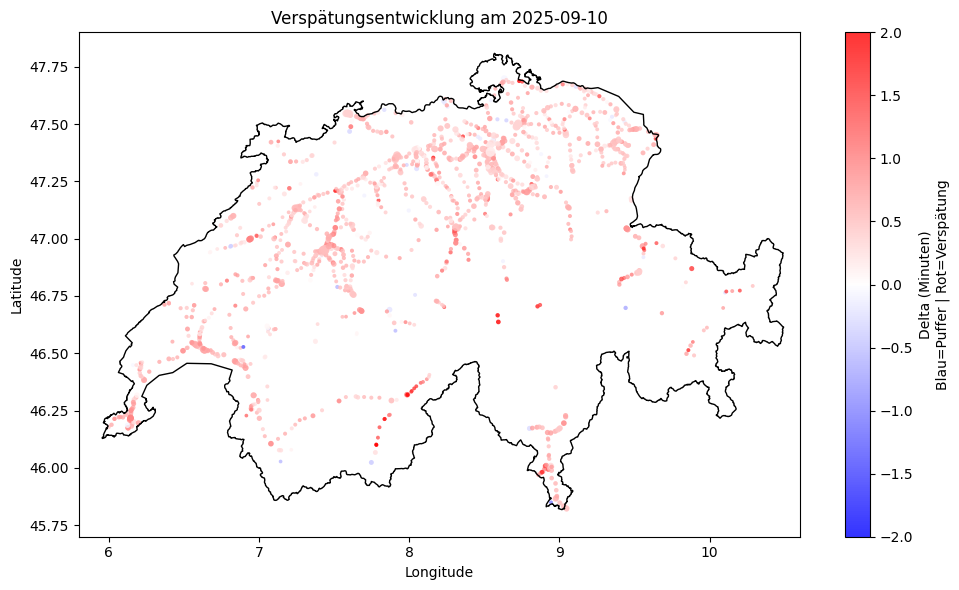

Plotting 2025-09-11...


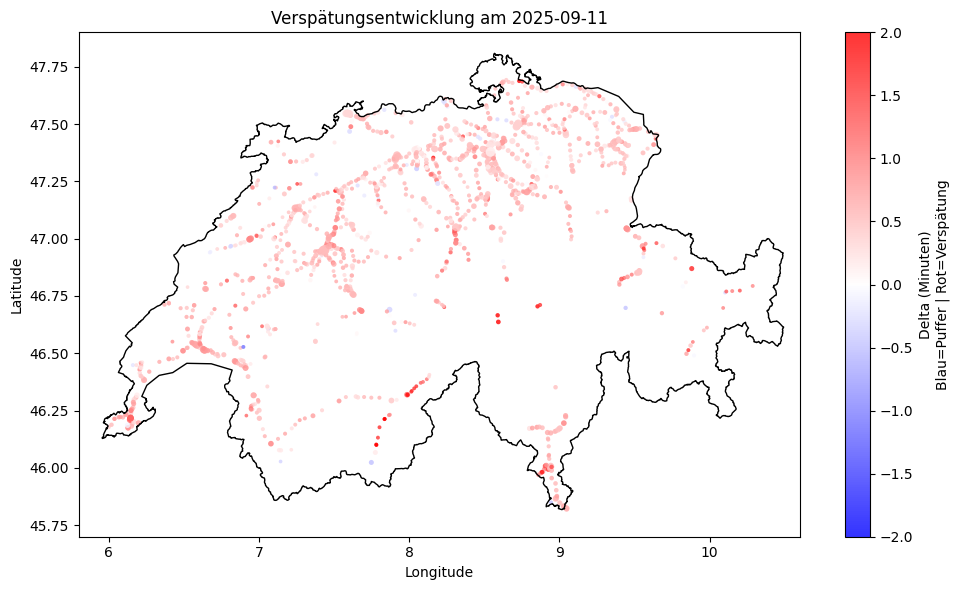

Plotting 2025-09-12...


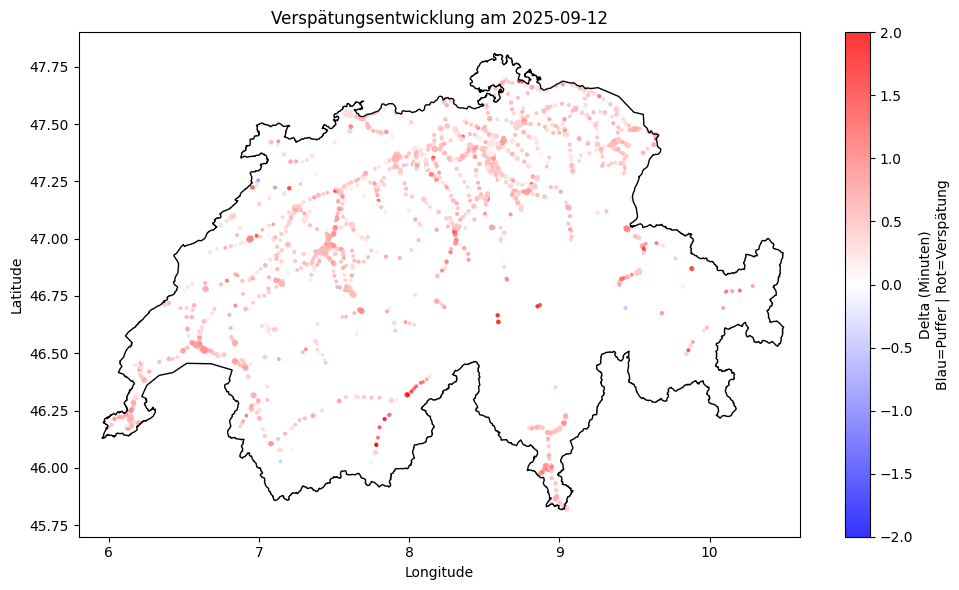

Plotting 2025-09-13...


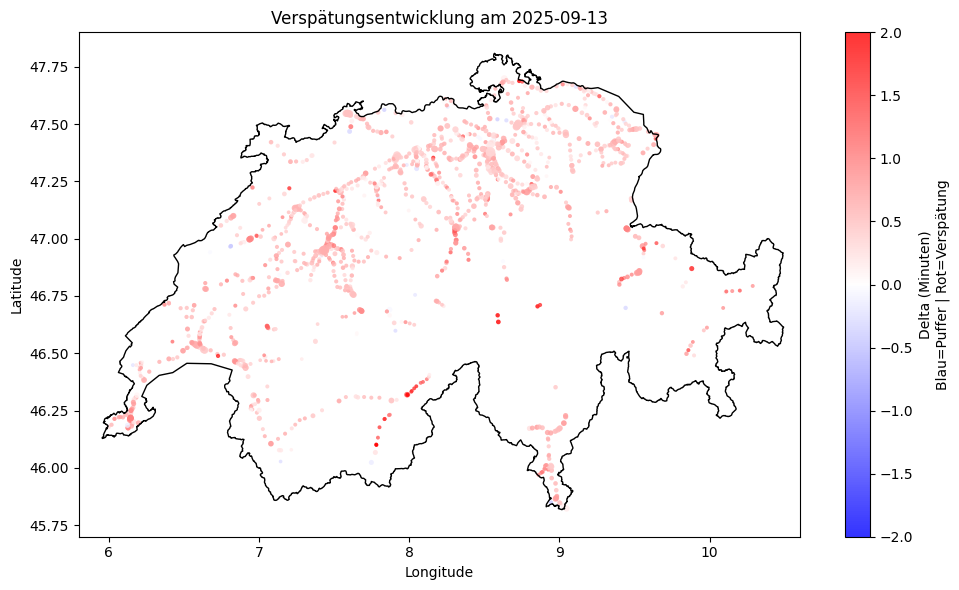

Plotting 2025-09-14...


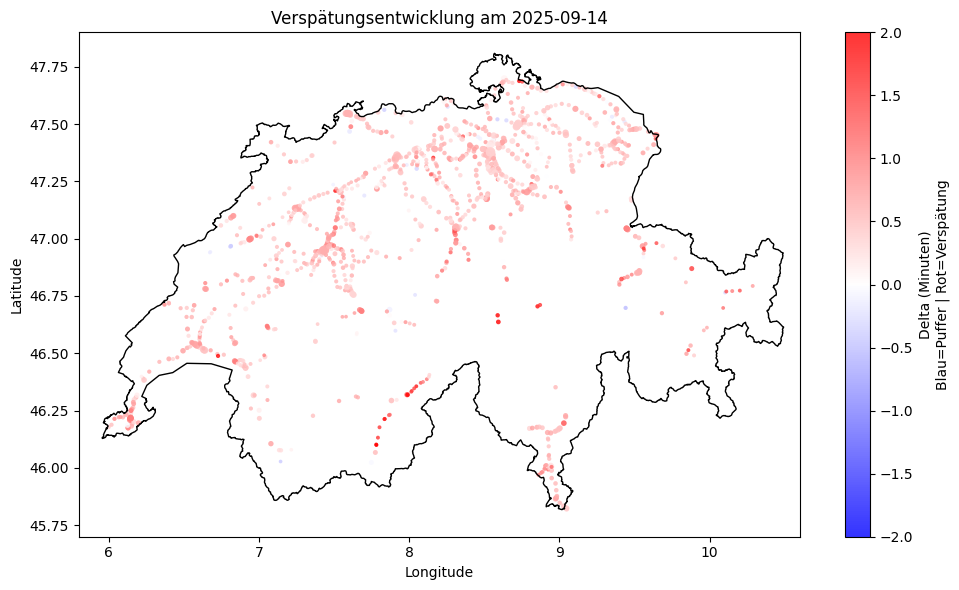

Plotting 2025-09-15...


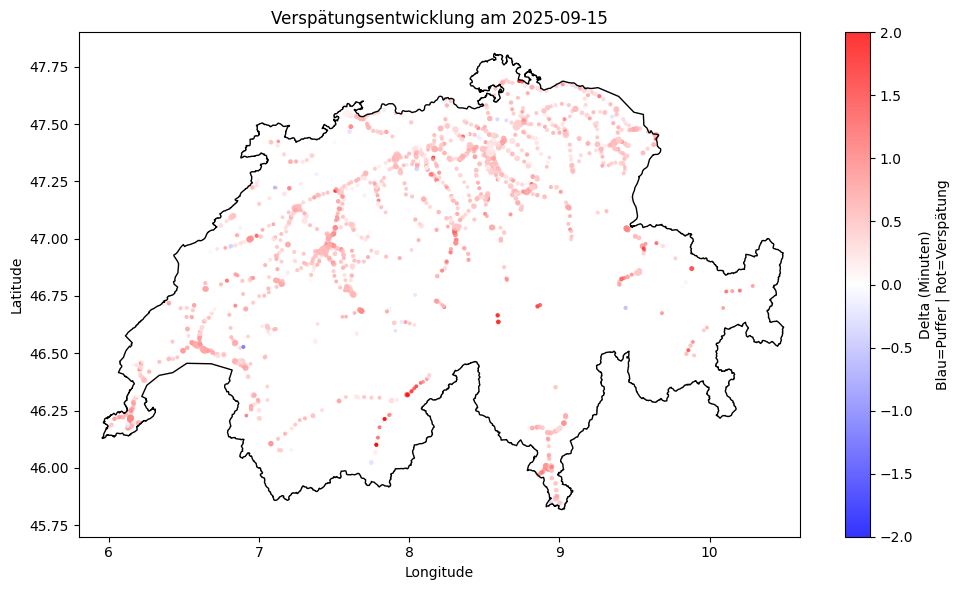

Plotting 2025-09-16...


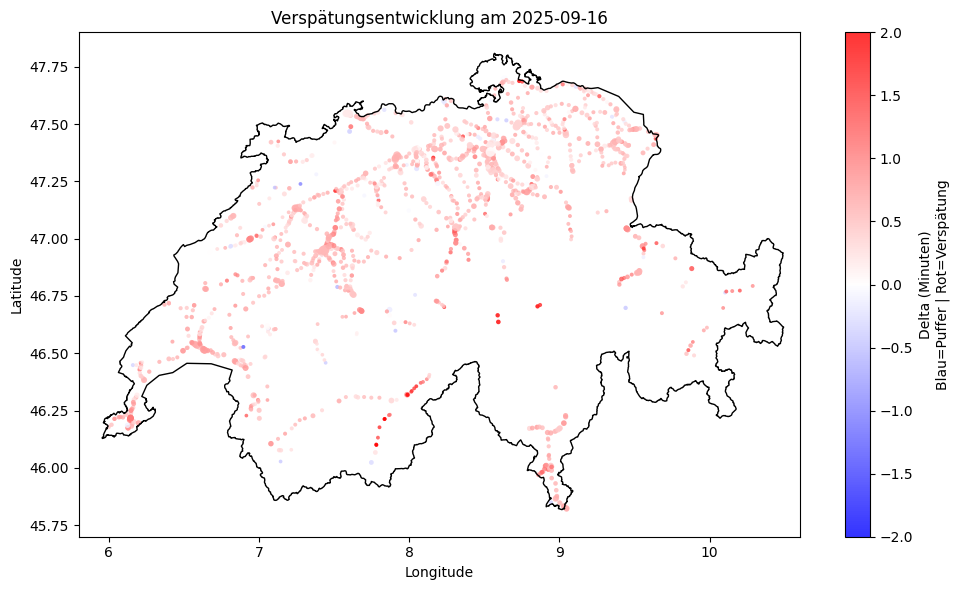

Plotting 2025-09-17...


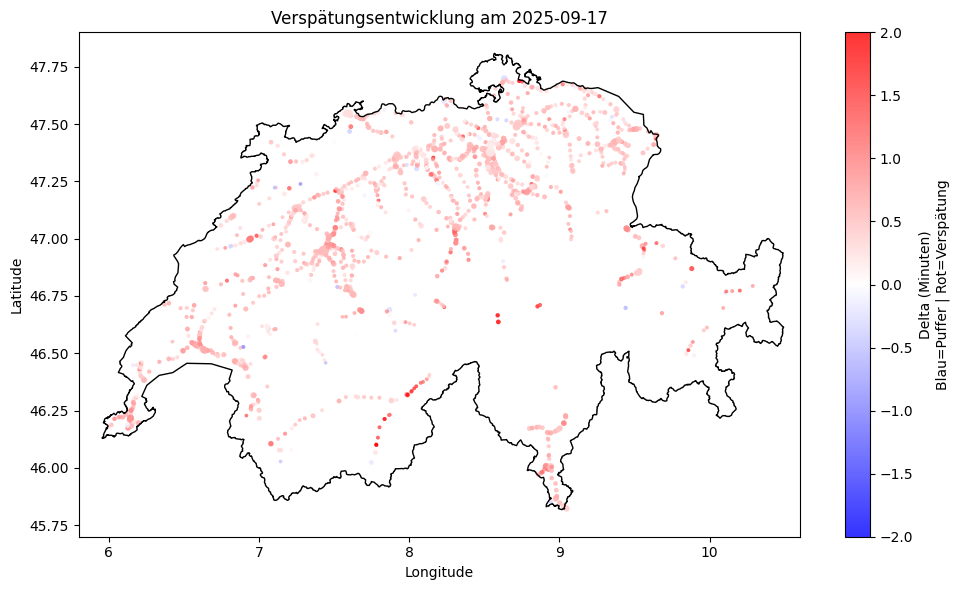

Plotting 2025-09-18...


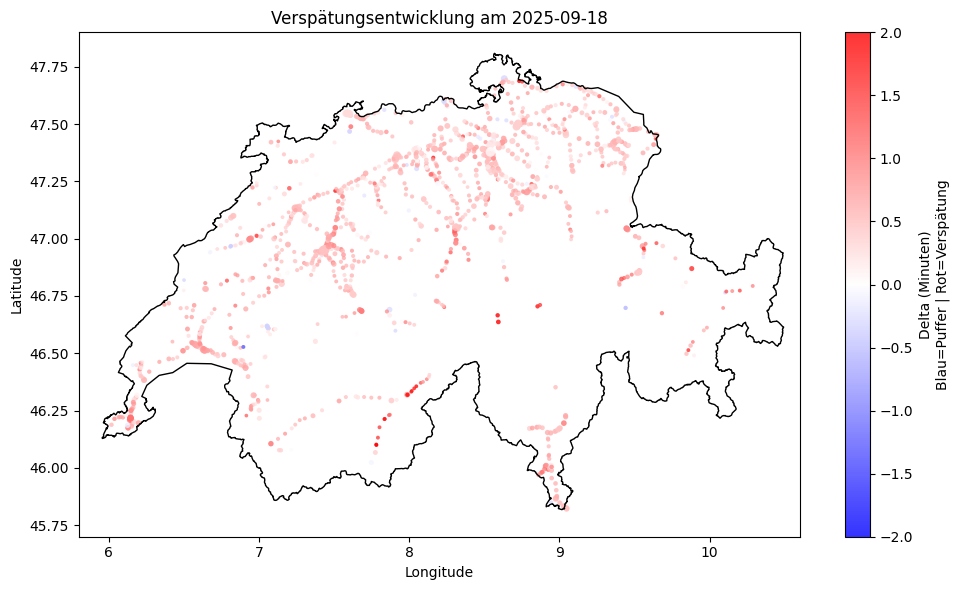

Plotting 2025-09-19...


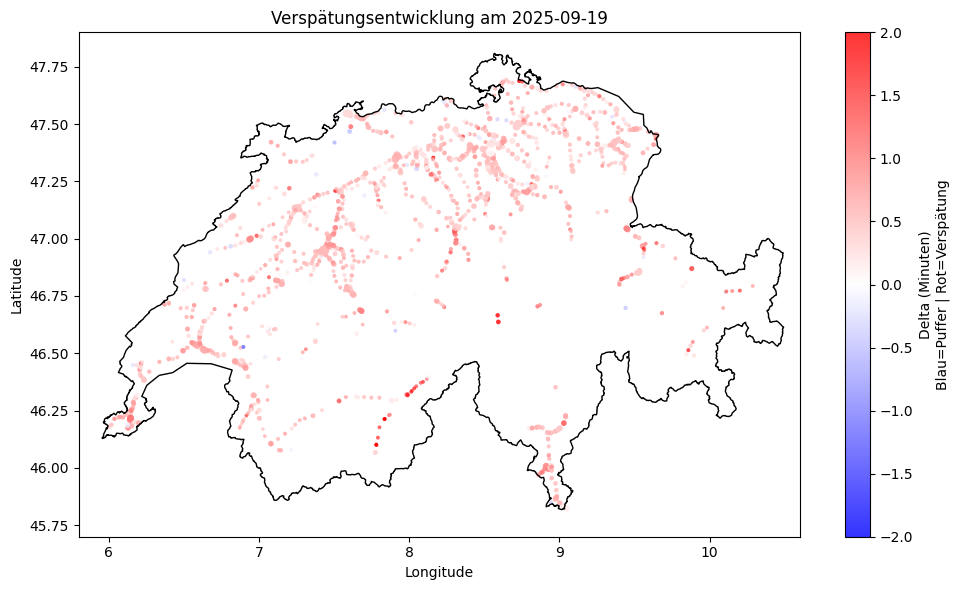

Plotting 2025-09-20...


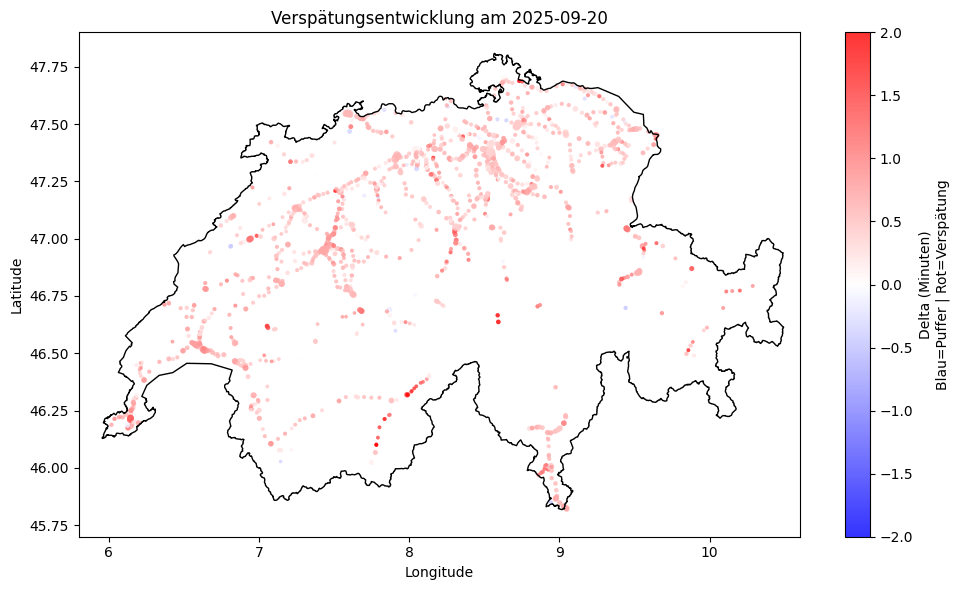

Plotting 2025-09-21...


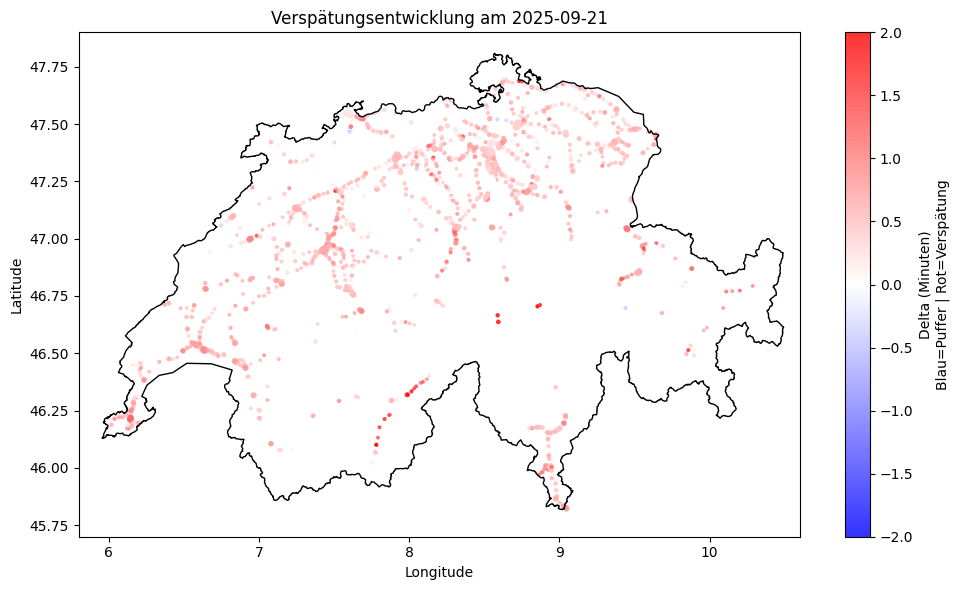

Plotting 2025-09-22...


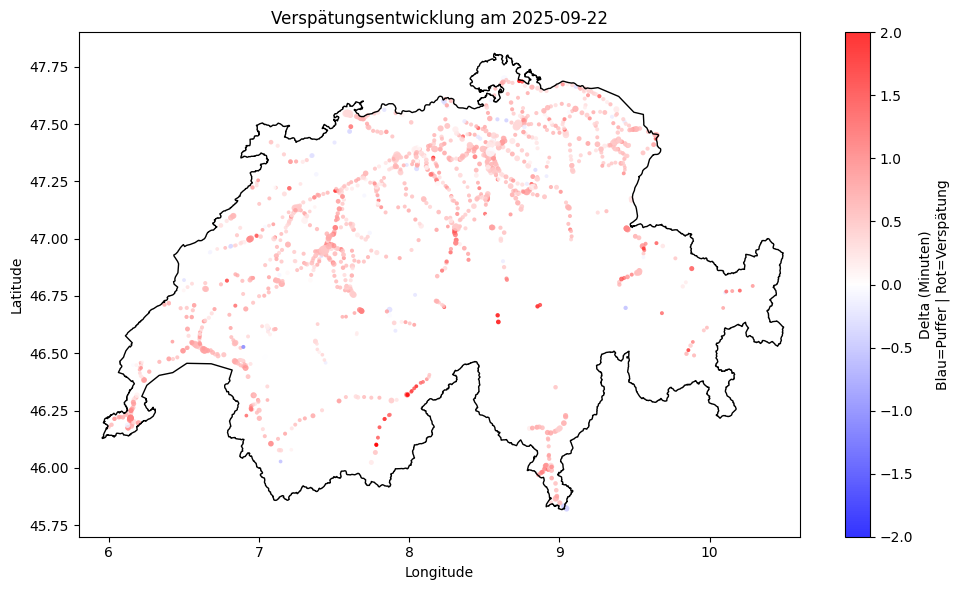

Plotting 2025-09-23...


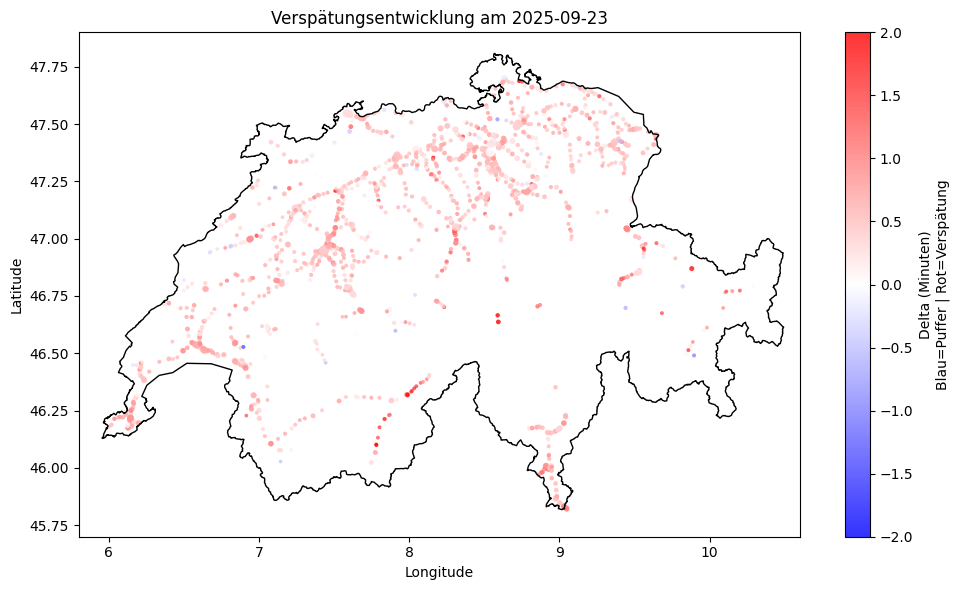

Plotting 2025-09-24...


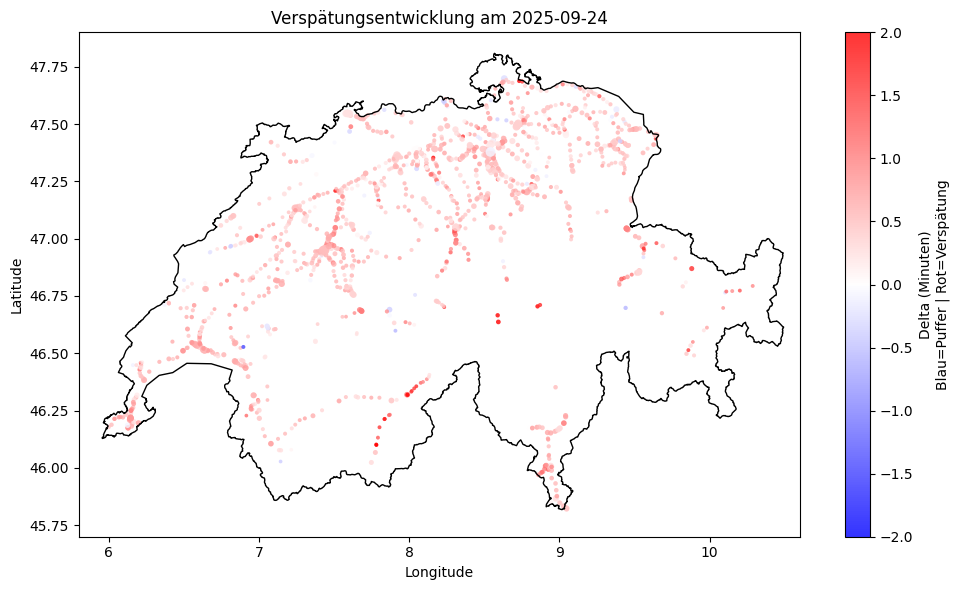

Plotting 2025-09-25...


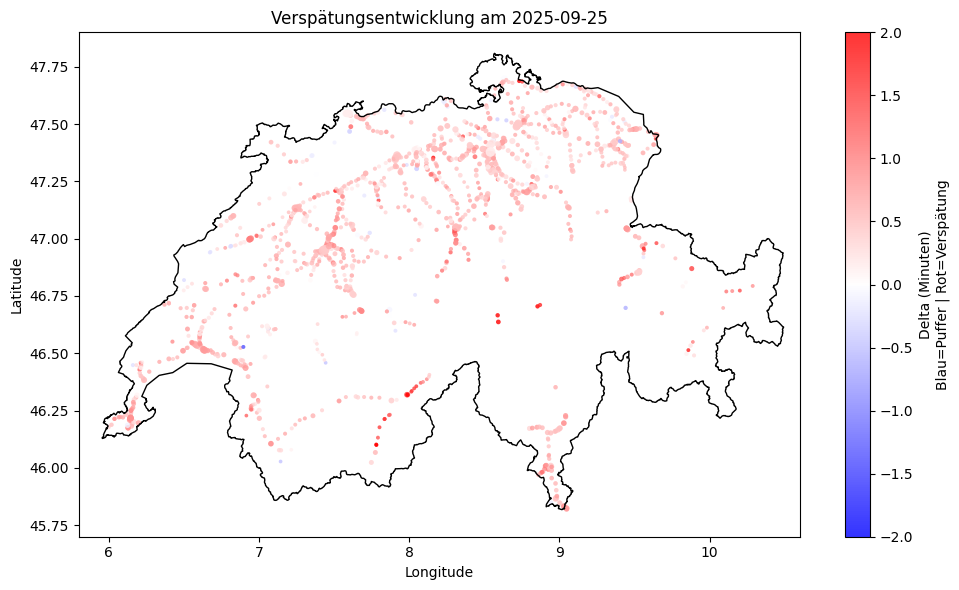

Plotting 2025-09-26...


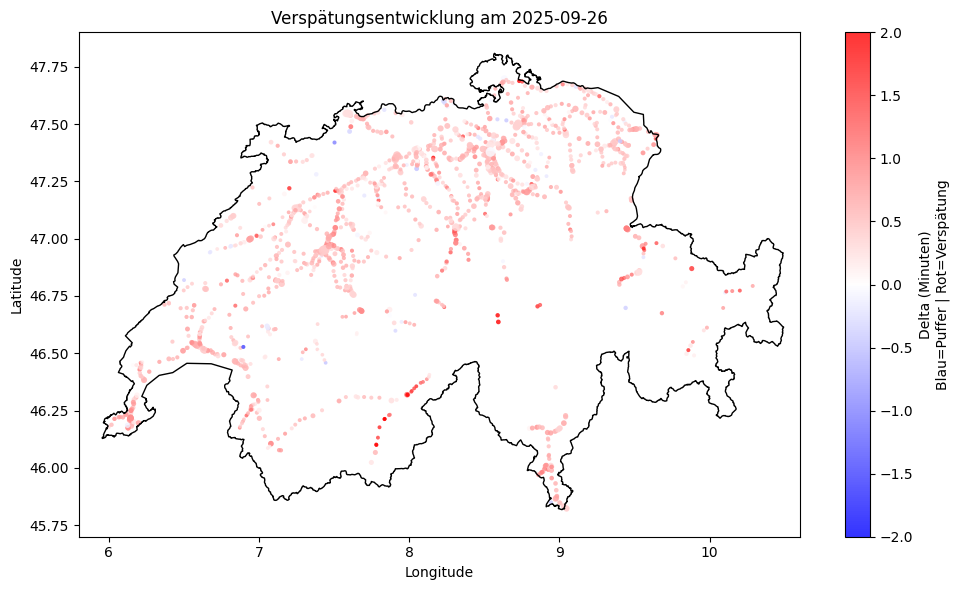

Plotting 2025-09-27...


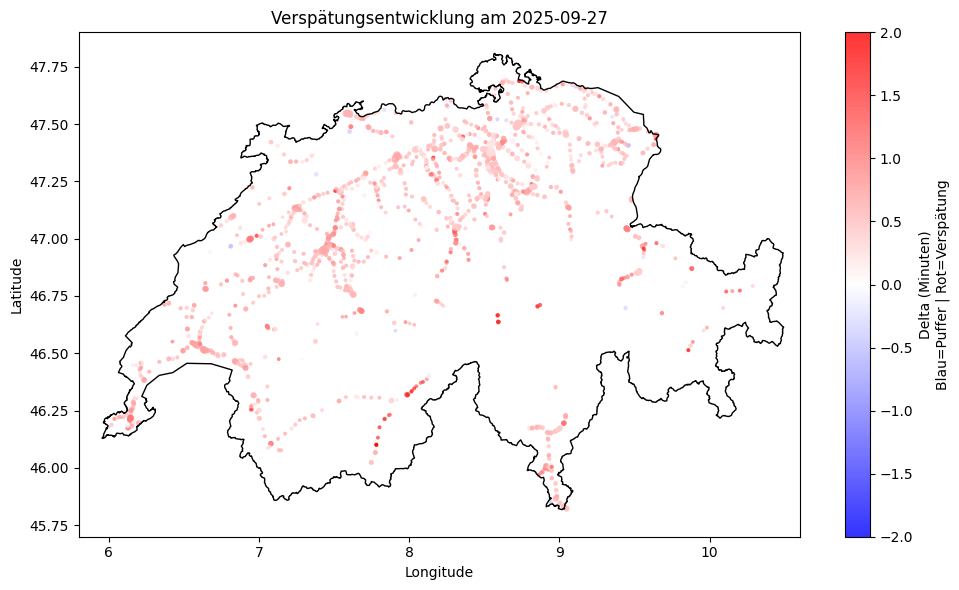

Plotting 2025-09-28...


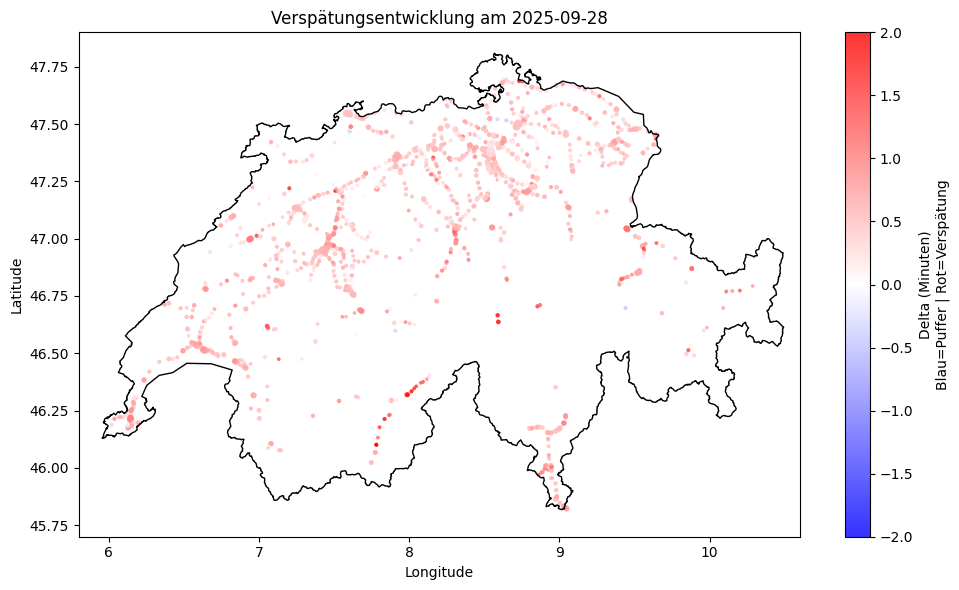

Plotting 2025-09-29...


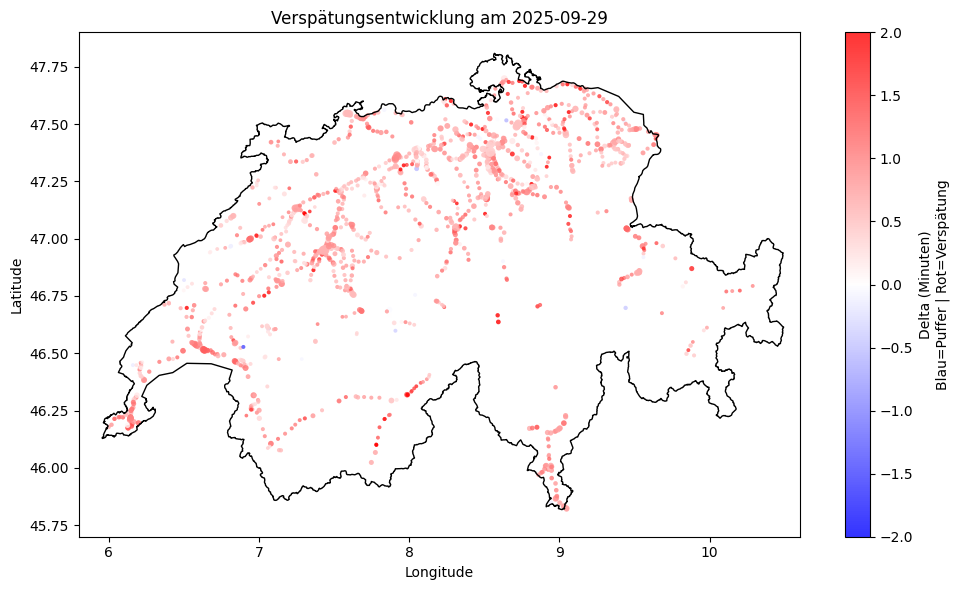

Plotting 2025-09-30...


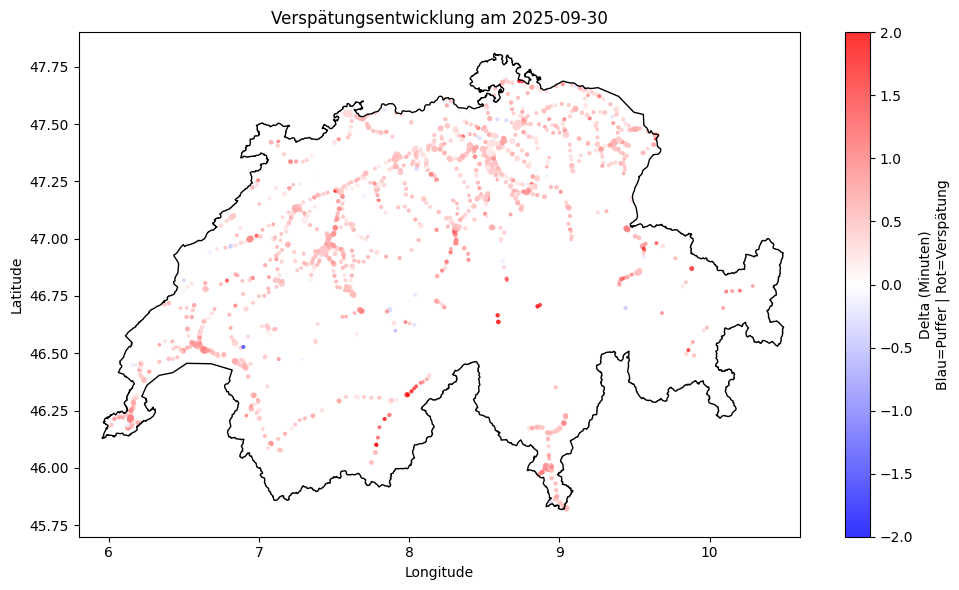

In [1]:
#  1. IMPORTS & KONFIGURATION
import sys
import json
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path

# Pfade definieren
DATA_PATH = Path("../data/processed/istdata_trains_clean.parquet")
STATION_PATH = Path("../data/external/dienststellen.csv")
BORDER_PATH = Path("../data/external/switzerland.geojson")

# Plot-Einstellungen
MIN_OBS_MONTH = 1000  # Mindestanzahl Züge pro Station für Monatsplot
MIN_OBS_DAY = 50      # Mindestanzahl Züge pro Station für Tagesplot
VMAX = 2.0            # Farbskala Limit (Minuten) für Konsistenz (Rot/Blau Sättigung)

#  2. HILFSFUNKTIONEN (Clean Code)

def load_and_prep_data(data_path, station_path):
    """Lädt Zugdaten und Stationen, bereinigt sie und verknüpft sie."""
    
    # A) Zugdaten laden & Delta berechnen
    df = pl.scan_parquet(data_path).collect()

    df = df.with_columns([
        ((pl.col("delay_departure_s") - pl.col("delay_arrival_s")) / 60).alias("delta_delay_min"),
        pl.col("BPUIC").cast(pl.Utf8) # Casting für Join
    ]).filter(
        pl.col("delta_delay_min").is_between(-60, 60) # Ausreisser filtern
    )

    # B) Stationsdaten (Geo) laden
    stops = pl.read_csv(station_path, separator=";")
    stops = stops.with_columns([
        pl.col("operatingPointKilometerMasterNumber").cast(pl.Utf8).alias("BPUIC"),
        pl.col("Geoposition").str.split(",").list.get(0).str.strip_chars().cast(pl.Float64).alias("lat"),
        pl.col("Geoposition").str.split(",").list.get(1).str.strip_chars().cast(pl.Float64).alias("lon")
    ]).select(["BPUIC", "lat", "lon"]).drop_nulls()

    return df, stops

def plot_switzerland_border(ax, json_path):
    """Zeichnet die Schweizer Grenze aus GeoJSON."""
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    for feat in data.get("feature", {}).get("geometry", {}).get("coordinates", []):
        # Einfache Logik für Polygon/MultiPolygon Struktur im spezifischen File
        coords = feat if isinstance(feat[0][0], float) else feat[0]
        # Falls tiefer verschachtelt (MultiPolygon)
        if not isinstance(coords[0], float) and not isinstance(coords[0][0], float):
             for poly in feat:
                 xs, ys = zip(*poly)
                 ax.plot(xs, ys, color="black", linewidth=1)
        else:
            # Fallback/Standard Handling je nach JSON Struktur
            # Hier vereinfacht: Wir loopen über die Segmente
            try:
                if isinstance(feat[0][0], list): # MultiPolygon Ring
                    xs, ys = zip(*feat[0])
                else:
                    xs, ys = zip(*feat)
                ax.plot(xs, ys, color="black", linewidth=1)
            except:
                pass # Ignoriere komplexe Geometrie-Fehler für Clean Code

def create_map_plot(data, title, filename=None):
    """Generische Funktion zum Erstellen der Karte."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Hintergrund (Grenze)
    try:
        plot_switzerland_border(ax, BORDER_PATH)
    except Exception as e:
        print(f"Warnung: Grenze konnte nicht gezeichnet werden ({e})")

    # Scatter Plot
    vals = data["mean_delta"].to_numpy()
    sc = ax.scatter(
        data["lon"], data["lat"], c=vals, cmap="bwr",
        vmin=-VMAX, vmax=VMAX, 
        s=data["n_obs"].to_numpy() ** 0.5, alpha=0.8, edgecolors="none"
    )
    
    # Layout
    plt.colorbar(sc, ax=ax, label="Delta (Minuten)\nBlau=Puffer | Rot=Verspätung")
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(5.8, 10.6)
    ax.set_ylim(45.7, 47.9)
    plt.tight_layout()
    
    if filename:
        # Optional: Speichern
        # plt.savefig(filename, dpi=150)
        pass
        
    plt.show()

#  3. DATEN LADEN
print("Lade Daten...")
df_trains, df_stops = load_and_prep_data(DATA_PATH, STATION_PATH)
print("Daten geladen.")

#  4. PLOT: GESAMTER MONAT
print("Erstelle Monats-Plot...")

# Aggregation
agg_month = (
    df_trains
    .group_by("BPUIC")
    .agg([
        pl.col("delta_delay_min").mean().alias("mean_delta"),
        pl.col("delta_delay_min").count().alias("n_obs")
    ])
    .filter(pl.col("n_obs") >= MIN_OBS_MONTH) # Filter kleine Stationen
    .join(df_stops, on="BPUIC", how="inner") # Geo-Daten dazu
)

create_map_plot(agg_month, "Durchschnittliche Verspätungsentwicklung (Gesamter Monat)")

# 5. PLOT: TAGES-SCHLEIFE (30 Tage)
print("Erstelle Tages-Plots...")

# Liste aller Tage im Datensatz sortieren
days = df_trains["BETRIEBSTAG"].unique().sort()

for day in days:
    print(f"Plotting {day}...")
    
    # Filter auf Tag + Aggregation
    agg_day = (
        df_trains
        .filter(pl.col("BETRIEBSTAG") == day)
        .group_by("BPUIC")
        .agg([
            pl.col("delta_delay_min").mean().alias("mean_delta"),
            pl.col("delta_delay_min").count().alias("n_obs")
        ])
        .filter(pl.col("n_obs") >= MIN_OBS_DAY) # Weniger Züge pro Tag nötig als pro Monat
        .join(df_stops, on="BPUIC", how="inner")
    )
    
    if agg_day.height > 0:
        create_map_plot(agg_day, f"Verspätungsentwicklung am {day}")
    else:
        print(f"Keine Daten für {day}")

